In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize_scalar

np.random.seed(0)

In [3]:
def get_coeff(c_1, c_2, scale):
    scale_sq = scale ** 2
    part1 = (c_1 - 1) / (c_1 + c_2) + scale_sq / (1 - scale_sq)
    part2 = part1 ** 2 + (scale_sq / (1 - scale_sq)) * 4 * c_2 / (c_1 + c_2)**2
    assert(part2 >= 0)
    
    a_1_option1 = (c_1 - 1) / (c_1 + c_2) - (part1 + math.sqrt(part2)) / 2
    a_1_option2 = (c_1 - 1) / (c_1 + c_2) - (part1 - math.sqrt(part2)) / 2
    isvalid_option1 = a_1_option1 > (c_1 - 1)/(c_1 + c_2) and a_1_option1 < c_1/(c_1 + c_2)
    isvalid_option2 = a_1_option2 > (c_1 - 1)/(c_1 + c_2) and a_1_option2 < c_1/(c_1 + c_2)

    assert(isvalid_option1 or isvalid_option2)
    assert(not (isvalid_option1 and isvalid_option2))
    
    a_1 = a_1_option1 if isvalid_option1 else a_1_option2
    a_2 = 1 - 1/(c_1 + c_2) - a_1
    return (a_1, a_2)

def te(c_1, c_2, scale):
    a_1, a_2 = get_coeff(c_1, c_2, scale)
    te = 1/ ((c_1 + c_2) * a_1 / scale**2 + (c_1 + c_2) * a_2)
    return te

## Complementary covariance matrices

In [4]:
def get_coeff2(c_1, c_2, scale):
    d = (scale - 1.0/scale)**2
    coeff = [0 for i in range(4)]
    coeff[0] = -d
    coeff[1] = d * (1 + (c_1 - 1.5)/(c_1 + c_2))
    coeff[2] = 1 - 1/(c_1 + c_2) - (1 - 1/(c_1 + c_2)) * ((c_1 - 0.5) / (c_1 + c_2)) * d
    coeff[3] = - (c_1/(c_1 + c_2)) * (1 - 1/(c_1 + c_2))**2
    A = np.roots(coeff)
    a_1 = 0
    num_valid = 0
    for a in A:
        if abs(np.imag(a)) <= 0.000001 and a > (c_1 - 1)/(c_1 + c_2) and a < c_1/(c_1 + c_2):
            a_1 = a
            num_valid += 1
            
    assert(num_valid == 1)
    a_2 = 1 - 1/(c_1 + c_2) - a_1
    return (a_1, a_2)

def te2(c_1, c_2, scale):
    if scale == 1:
        return 1/ (c_1 + c_2 - 1)
    
    a_1, a_2 = get_coeff2(c_1, c_2, scale)
    scale_sq = scale**2
    te = 0.5 / ((c_1 + c_2) * (scale_sq * a_1 + a_2))
    te += 0.5 / ((c_1 + c_2) * (a_1 / scale_sq + a_2))
    return te

In [5]:
c_1 = 4.0
c_2 = 4.0
scale = 10.0

te2(c_1, c_2, scale)

0.14285714285714293

# empirical

In [6]:
# params
p = 200
c1 = 4
c2 = 4
n2 = c2 * p
sigma = 0.5

# covariates
X2 = np.random.randn(n2, p)

# models
beta_t = np.random.randn(p, 1) / math.sqrt(p)

# labels
Y2 = X2 @ beta_t + sigma * np.random.randn(n2, 1)
hat_beta_t = np.linalg.inv(X2.T @ X2) @ X2.T @ Y2

def te_target(X1, X2, beta_s, beta_t, w, sigma_2 = sigma, Sigma2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma_2**2 * np.trace(K @ Sigma2_sqrt @ Sigma2_sqrt)
    model_shift_bias = w**2 * np.linalg.norm(Sigma2_sqrt @ K @ X1.T @ X1 @ beta_diff) **2
    return model_shift_bias + var

def mtl_target(X1, X2, beta_s, beta_t, w, n1, n2, Sigma_1_sqrt = np.eye(p), Sigma_2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma**2 * (n1 + n2) * np.trace(K)
    model_shift_bias = n1 * (np.linalg.norm(K @ X2.T @ X2 @ beta_diff) ** 2)
    model_shift_bias += n2 * w**2 * (np.linalg.norm(K @ X1.T @ X1 @ beta_diff) ** 2)
    return (model_shift_bias + var) / (n1 + n2)

In [7]:
def opt_w_val(X1, X2, beta_s, beta_t, n1, n2, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f_val(w):
        return mtl_target(X1, X2, beta_s, beta_t, w, n1, n2)
    
    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f_val, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
    
    plt.figure(c)
    plt.plot(x_list, fun_list)
    
    return x_list[np.argmin(fun_list)]

def opt_w(X1, X2, beta_s, beta_t, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f(w):
        return te_target(X1, X2, beta_s, beta_t, w)

    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
        
    plt.figure(c)
    plt.plot(x_list, fun_list)
        
    return x_list[np.argmin(fun_list)]

In [45]:
d = 0.00
c1_list = np.array([i for i in range(1, 21)])
scale_list = [1, 2, 4]

te_mtl_list = []

provable_pos = [[], []]
provable_neg = [[], []]
unknown = [[], []]

beta_s = beta_t + d * np.random.randn(p, 1)

for s in scale_list:
    s_diag = s * np.ones(p)
    for i in range(int(p/2), p):
        s_diag[i] = s_diag[i] / s**2

    for c1 in c1_list:
        n1 = c1 * p
        X1 = np.random.randn(n1, p) @ np.diag(s_diag)
        Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

        #hat_beta_st = np.linalg.inv(X1.T @ X1 + X2.T @ X2) @ (X1.T @ Y1 + X2.T @ Y2)
        hat_w = 1 # opt_w_val(X1, X2, beta_s, beta_t, n1, n2)
        te_beta_st = te_target(X1, X2, beta_s, beta_t, hat_w)

        #te_beta_st = np.linalg.norm(test_X2 @ hat_beta_st - test_Y2) ** 2 / test_n2
        te_mtl_list.append(te_beta_st)

        #delta_beta_base = p * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
        #delta_beta = ((1 - hat_w)**2 + d**2) * delta_beta_base
        #delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
        #deviation_ub = (1 + math.sqrt(1/c1))**4
        #deviation_lb = (1 - math.sqrt(1/c1))**4

        #if delta_var / delta_beta > deviation_ub:
        #    provable_pos[0].append(c1)
        #    provable_pos[1].append(te_beta_st)
        #elif delta_var / delta_beta < deviation_lb:    
        #    provable_neg[0].append(c1)
        #    provable_neg[1].append(te_beta_st)
        #else:
        #    unknown[0].append(c1)
        #    unknown[1].append(te_beta_st)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


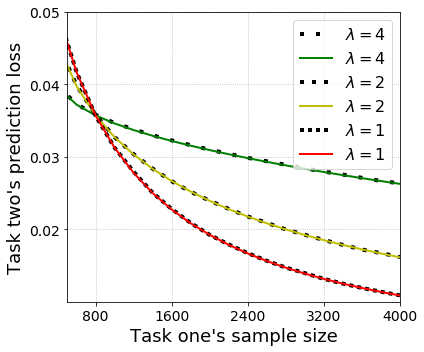

In [84]:
plt.figure(figsize=(6,5))

for i, ts in enumerate(te_list):
    if i == 2:
        plt.plot(c1_list * p, te_emp_list[i], c='k', linestyle='--', dashes=(1, 3), lw=4, label='$\lambda = 4$')
        plt.plot(c1_list * p, ts, c='g', lw=2, label=r'$\lambda = 4$')

for i, ts in enumerate(te_list):
    if i == 1:
        plt.plot(c1_list * p, te_emp_list[i], linestyle='--', dashes=(1, 2), lw=4, c='k', label='$\lambda = 2$')
        plt.plot(c1_list * p, ts, c='y', lw=2, label=r'$\lambda = 2$')
        
for i, ts in enumerate(te_list):
    if i == 0:
        plt.plot(c1_list * p,  te_emp_list[i], linestyle='--', dashes=(1, 1),  c='k', lw=4, label=r'$\lambda = 1$')
        plt.plot(c1_list * p, ts, c='r', lw=2, label=r'$\lambda = 1$')
        
plt.xlabel('Task one\'s sample size', fontsize=18)
plt.ylabel('Task two\'s prediction loss', fontsize=18)
#axes = plt.gca()
#axes.set_xlim([1.0, 20.0])

plt.yticks(np.arange(0.02, 0.06, 0.01), fontsize=14)
plt.xticks(np.arange(800, 4800, 800), fontsize=14)
plt.xlim([500, 4000])
plt.ylim([0.01, 0.05])


plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=16)#,loc=3)
plt.tight_layout()
plt.savefig('covariate_shift.eps')